In [1]:
import pickle, yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def saveFig(name, fig):
    fig.savefig(
        name,
        dpi=None,
        facecolor=fig.get_facecolor(),
        edgecolor="none",
        orientation="portrait",
        format="png",
        transparent=False,
        bbox_inches="tight",
        pad_inches=0.2,
        metadata=None,
    )

In [3]:
def read_pickle_and_config(path_to_pickle):
    with open(path_to_pickle, "rb") as handle:
        data = pickle.load(handle)

    config_path = Path(path_to_pickle).parent / ".hydra" / "config.yaml"
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    return data, config

In [4]:
def fuse_by_dataset(losses):
    """Transform per-round history (list of dicts) into
    
    a single dict, with values as lists."""
    fussed_losses = {}

    for _, loss_dict in losses:
        for k,v in loss_dict.items():
            if k in fussed_losses:
                fussed_losses[k].append(v)
            else:
                fussed_losses[k] = [v]
    return fussed_losses

In [5]:
def process_multirun_data(path_multirun):
    print(path_multirun)
    """Given a path to a multirun directory, this loads the history of all runs"""
    res_list = []
    for results in list(Path(path_multirun).glob("**/history.pkl")):
        data, config = read_pickle_and_config(results)
        pre_train_loss = data['history'].metrics_distributed_fit['pre_train_losses']
        fussed_losses = fuse_by_dataset(pre_train_loss)
        res_list.append({'strategy': config['client']['client_label'], 'train_losses': fussed_losses})
    return res_list

In [6]:
# Here replace with the path of the multi run you just comleted
all_losses = process_multirun_data('../multirun/2023-11-15/22-05-50')

../multirun/2023-11-15/22-05-50


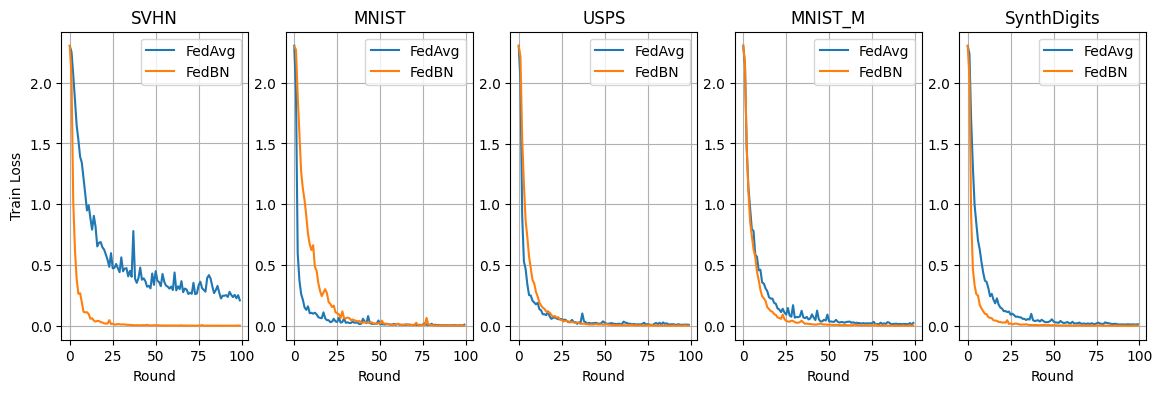

In [7]:
num_datasets = 5
fig, axs = plt.subplots(figsize=(14,4), nrows=1, ncols=num_datasets)

for e_id, experiment in enumerate(all_losses):
    for i, (dataset, loss) in enumerate(experiment['train_losses'].items()):
        axs[i].plot(range(len(loss)), loss, label=experiment['strategy'])
        axs[i].set_xlabel('Round')
        if i == 0:
            axs[i].set_ylabel('Train Loss')

        axs[i].legend()
        if e_id==0:
            axs[i].grid()
            axs[i].set_title(dataset)
            axs[i].set_xticks(np.arange(0,100+1, 25))
saveFig('train_loss.png', fig)